In [1]:
import argparse
import itertools

import torch
import triton
import triton.language as tl
import triton.profiler as proton
from triton.tools.tensor_descriptor import TensorDescriptor
from contextlib import contextmanager

from typing import Optional

if torch.cuda.is_available():
    from triton._C.libtriton import nvidia
    cublas_workspace = torch.empty(32 * 1024 * 1024, device="cuda", dtype=torch.uint8)
    cublas = nvidia.cublas.CublasLt(cublas_workspace)
else:
    cublas = None


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def supports_tma():
    return is_cuda() and torch.cuda.get_device_capability()[0] >= 9


def is_hopper():
    return torch.cuda.get_device_capability()[0] == 9


def supports_ws():
    return is_cuda() and torch.cuda.get_device_capability()[0] >= 9

# device TMA api
HAS_TENSOR_DESC = supports_tma() and hasattr(tl, "make_tensor_descriptor")
# host TMA api
HAS_HOST_TENSOR_DESC = supports_tma() and hasattr(triton.tools.tensor_descriptor, "TensorDescriptor")
HAS_WARP_SPECIALIZE = supports_ws() and HAS_TENSOR_DESC

print(f"supports_tma: {supports_tma()}")
print(f"is_hopper: {is_hopper()}")
print(f"supports_ws: {supports_ws()}")
print(f"HAS_TENSOR_DESC: {HAS_TENSOR_DESC}")
print(f"HAS_HOST_TENSOR_DESC: {HAS_HOST_TENSOR_DESC}")
print(f"HAS_WARP_SPECIALIZE: {HAS_WARP_SPECIALIZE}")

supports_tma: True
is_hopper: True
supports_ws: True
HAS_TENSOR_DESC: True
HAS_HOST_TENSOR_DESC: True
HAS_WARP_SPECIALIZE: True


In [2]:
def cublas_matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[1], "Incompatible dimensions"  # b is transposed
    M, K = a.shape
    N, K = b.shape
    dtype = a.dtype
    c = torch.empty((M, N), device=a.device, dtype=dtype)
    bytes_per_elem = a.element_size()
    flops_str = f"flops{bytes_per_elem * 8}"
    with proton.scope(f"cublas [M={M}, N={N}, K={K}]",
                      {"bytes": bytes_per_elem * (M * K + N * K + M * N), flops_str: 2. * M * N * K}):
        cublas.matmul(a, b, c)
    return c


def torch_matmul(a, b):
    M, K = a.shape
    N, K = b.shape
    bytes_per_elem = a.element_size()
    flops_str = f"flops{bytes_per_elem * 8}"
    with proton.scope(f"torch [M={M}, N={N}, K={K}]",
                      {"bytes": bytes_per_elem * (M * K + N * K + M * N), flops_str: 2. * M * N * K}):
        c = torch.matmul(a, b.T)
    return c


@contextmanager
def proton_context():
    proton.activate(0)
    try:
        yield
    finally:
        proton.deactivate(0)


def bench_fn(label, reps, warmup_reps, fn, *args):
    print(f"Benchmarking {label}: ...", end="")
    for _ in range(warmup_reps):
        fn(*args)
    with proton_context():
        for _ in range(reps):
            fn(*args)
    print(f"\rBenchmarking {label}: done")


def run_test(expect, fn, a, b, label, enabled=True):
    print(f"  {label}: ...", end="")
    if enabled:
        actual = fn(a, b)
        passed = torch.allclose(expect, actual.to(expect.dtype), atol=1.0)
        icon = "✅" if passed else "❌"
    else:
        icon = "⭕"
    print(f"\r  {label}: {icon}  ")
    
# Add some launch metadata
def _matmul_launch_metadata(grid, kernel, args):
    ret = {}
    M, N, K, WS = args["M"], args["N"], args["K"], args.get("WARP_SPECIALIZE", False)
    ws_str = "_ws" if WS else ""
    ret["name"] = f"{kernel.name}{ws_str} [M={M}, N={N}, K={K}]"
    if "c_ptr" in args:
        bytes_per_elem = args["c_ptr"].element_size()
    else:
        bytes_per_elem = 1 if args["FP8_OUTPUT"] else 2
    ret[f"flops{bytes_per_elem * 8}"] = 2. * M * N * K
    ret["bytes"] = bytes_per_elem * (M * K + N * K + M * N)
    return ret

# Matmul

In [3]:
# Non-persistent
def matmul_get_configs(pre_hook=None):
    return [
        triton.Config({'BLOCK_SIZE_M': BM, 'BLOCK_SIZE_N': BN, "BLOCK_SIZE_K": BK, "GROUP_SIZE_M": 8}, num_stages=s,
                      num_warps=w, pre_hook=pre_hook)
        for BM in [128]
        for BN in [128, 256]
        for BK in [64, 128]
        for s in ([2, 3, 4])
        for w in [4, 8]
    ]


@triton.autotune(
    configs=matmul_get_configs(),
    key=["M", "N", "K"],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def matmul_kernel(a_ptr, b_ptr, c_ptr,  #
                  M, N, K,  #
                  stride_am, stride_ak,  #
                  stride_bk, stride_bn,  #
                  stride_cm, stride_cn,  #
                  BLOCK_SIZE_M: tl.constexpr,  #
                  BLOCK_SIZE_N: tl.constexpr,  #
                  BLOCK_SIZE_K: tl.constexpr,  #
                  GROUP_SIZE_M: tl.constexpr,  #
                  ):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    start_m = pid_m * BLOCK_SIZE_M
    start_n = pid_n * BLOCK_SIZE_N

    offs_am = start_m + tl.arange(0, BLOCK_SIZE_M)
    offs_bn = start_n + tl.arange(0, BLOCK_SIZE_N)
    offs_am = tl.where(offs_am < M, offs_am, 0)
    offs_bn = tl.where(offs_bn < N, offs_bn, 0)

    offs_am = tl.max_contiguous(tl.multiple_of(offs_am, BLOCK_SIZE_M), BLOCK_SIZE_M)
    offs_bn = tl.max_contiguous(tl.multiple_of(offs_bn, BLOCK_SIZE_N), BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    if (c_ptr.dtype.element_ty == tl.float8e4nv):
        c = accumulator.to(tl.float8e4nv)
    else:
        c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.dtype == b.dtype, "Incompatible dtypes"
    M, K = a.shape
    K, N = b.shape
    dtype = a.dtype

    c = torch.empty((M, N), device=a.device, dtype=dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c

In [4]:
# Multimul persistent
@triton.jit
def _compute_pid(tile_id, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS):
    group_id = tile_id // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (tile_id % group_size_m)
    pid_n = (tile_id % num_pid_in_group) // group_size_m
    return pid_m, pid_n


@triton.autotune(
    configs=matmul_get_configs(),
    key=["M", "N", "K"],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def matmul_kernel_persistent(a_ptr, b_ptr, c_ptr,  #
                             M, N, K,  #
                             stride_am, stride_ak,  #
                             stride_bk, stride_bn,  #
                             stride_cm, stride_cn,  #
                             BLOCK_SIZE_M: tl.constexpr,  #
                             BLOCK_SIZE_N: tl.constexpr,  #
                             BLOCK_SIZE_K: tl.constexpr,  #
                             GROUP_SIZE_M: tl.constexpr,  #
                             NUM_SMS: tl.constexpr,  #
                             ):
    start_pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    k_tiles = tl.cdiv(K, BLOCK_SIZE_K)
    num_tiles = num_pid_m * num_pid_n

    # NOTE: There is currently a bug in blackwell pipelining that means it can't handle a value being
    # used in both the prologue and epilogue, so we duplicate the counters as a work-around.
    tile_id_c = start_pid - NUM_SMS

    offs_k_for_mask = tl.arange(0, BLOCK_SIZE_K)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n

    for tile_id in tl.range(start_pid, num_tiles, NUM_SMS, flatten=True):
        pid_m, pid_n = _compute_pid(tile_id, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        start_m = pid_m * BLOCK_SIZE_M
        start_n = pid_n * BLOCK_SIZE_N
        offs_am = start_m + tl.arange(0, BLOCK_SIZE_M)
        offs_bn = start_n + tl.arange(0, BLOCK_SIZE_N)
        offs_am = tl.where(offs_am < M, offs_am, 0)
        offs_bn = tl.where(offs_bn < N, offs_bn, 0)
        offs_am = tl.max_contiguous(tl.multiple_of(offs_am, BLOCK_SIZE_M), BLOCK_SIZE_M)
        offs_bn = tl.max_contiguous(tl.multiple_of(offs_bn, BLOCK_SIZE_N), BLOCK_SIZE_N)

        accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
        for ki in range(k_tiles):
            offs_k = ki * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
            a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
            b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

            a = tl.load(a_ptrs, mask=offs_k_for_mask[None, :] < K - ki * BLOCK_SIZE_K, other=0.0)
            b = tl.load(b_ptrs, mask=offs_k_for_mask[:, None] < K - ki * BLOCK_SIZE_K, other=0.0)
            accumulator = tl.dot(a, b, accumulator)

        tile_id_c += NUM_SMS
        pid_m, pid_n = _compute_pid(tile_id_c, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
        offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
        c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
        c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
        if (c_ptr.dtype.element_ty == tl.float8e4nv):
            c = accumulator.to(tl.float8e4nv)
        else:
            c = accumulator.to(tl.float16)
        tl.store(c_ptrs, c, mask=c_mask)


def matmul_persistent(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.dtype == b.dtype, "Incompatible dtypes"
    NUM_SMS = torch.cuda.get_device_properties("cuda").multi_processor_count
    M, K = a.shape
    K, N = b.shape
    dtype = a.dtype
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (min(NUM_SMS, triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"])), )
    matmul_kernel_persistent[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        NUM_SMS=NUM_SMS,  #
    )
    return c

# Matmul TMA

In [5]:
# matmul_kernel_tma
def matmul_tma_set_block_size_hook(nargs):
    EPILOGUE_SUBTILE = nargs.get("EPILOGUE_SUBTILE", False)
    BLOCK_M = nargs["BLOCK_SIZE_M"]
    BLOCK_N = nargs["BLOCK_SIZE_N"]
    BLOCK_K = nargs["BLOCK_SIZE_K"]
    nargs["a_desc"].block_shape = [BLOCK_M, BLOCK_K]
    nargs["b_desc"].block_shape = [BLOCK_N, BLOCK_K]
    if EPILOGUE_SUBTILE:
        nargs["c_desc"].block_shape = [BLOCK_M, BLOCK_N // 2]
    else:
        nargs["c_desc"].block_shape = [BLOCK_M, BLOCK_N]


@triton.autotune(
    configs=matmul_get_configs(pre_hook=matmul_tma_set_block_size_hook),
    key=["M", "N", "K", "WARP_SPECIALIZE"],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def matmul_kernel_tma(a_desc, b_desc, c_desc,  #
                      M, N, K,  #
                      BLOCK_SIZE_M: tl.constexpr,  #
                      BLOCK_SIZE_N: tl.constexpr,  #
                      BLOCK_SIZE_K: tl.constexpr,  #
                      GROUP_SIZE_M: tl.constexpr,  #
                      FP8_OUTPUT: tl.constexpr,  #
                      WARP_SPECIALIZE: tl.constexpr,  #
                      ):
    dtype = tl.float8e4nv if FP8_OUTPUT else tl.float16

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    k_tiles = tl.cdiv(K, BLOCK_SIZE_K)

    offs_am = pid_m * BLOCK_SIZE_M
    offs_bn = pid_n * BLOCK_SIZE_N

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for k in tl.range(k_tiles, warp_specialize=WARP_SPECIALIZE):
        offs_k = k * BLOCK_SIZE_K
        a = a_desc.load([offs_am, offs_k])
        b = b_desc.load([offs_bn, offs_k])
        accumulator = tl.dot(a, b.T, accumulator)

    c = accumulator.to(dtype)

    offs_cm = pid_m * BLOCK_SIZE_M
    offs_cn = pid_n * BLOCK_SIZE_N
    c_desc.store([offs_cm, offs_cn], c)


def matmul_tma(a, b, warp_specialize: bool):
    # Check constraints.
    assert a.shape[1] == b.shape[1], "Incompatible dimensions"  # b is transposed
    assert a.dtype == b.dtype, "Incompatible dtypes"

    M, K = a.shape
    N, K = b.shape
    dtype = a.dtype

    c = torch.empty((M, N), device=a.device, dtype=dtype)

    # A dummy block value that will be overwritten when we have the real block size
    dummy_block = [1, 1]
    a_desc = TensorDescriptor(a, a.shape, a.stride(), dummy_block)
    b_desc = TensorDescriptor(b, b.shape, b.stride(), dummy_block)
    c_desc = TensorDescriptor(c, c.shape, c.stride(), dummy_block)

    def grid(META):
        BLOCK_M = META["BLOCK_SIZE_M"]
        BLOCK_N = META["BLOCK_SIZE_N"]
        return (triton.cdiv(M, BLOCK_M) * triton.cdiv(N, BLOCK_N), )

    matmul_kernel_tma[grid](
        a_desc, b_desc, c_desc,  #
        M, N, K,  #
        FP8_OUTPUT=dtype == torch.float8_e4m3fn,  #
        WARP_SPECIALIZE=warp_specialize,  #
    )
    return c


In [ ]:
# tma persistent, Host side TMA Tensor Descriptor. Hopper 不支持 warp spec + host side TMA api 同时开启
def matmul_tma_persistent_get_configs(pre_hook=None):
    return [
        triton.Config(
            {
                'BLOCK_SIZE_M': BM, 'BLOCK_SIZE_N': BN, "BLOCK_SIZE_K": BK, "GROUP_SIZE_M": 8, "EPILOGUE_SUBTILE":
                SUBTILE
            }, num_stages=s, num_warps=w, pre_hook=pre_hook)  #
        for BM in [128]  #
        for BN in [128, 256]  #
        for BK in [64, 128]  #
        for s in ([2, 3, 4])  #
        for w in [4, 8]  #
        for SUBTILE in [True, False]  #
    ]


@triton.autotune(
    configs=matmul_tma_persistent_get_configs(pre_hook=matmul_tma_set_block_size_hook),
    key=["M", "N", "K", "WARP_SPECIALIZE"],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def matmul_kernel_tma_persistent(a_desc, b_desc, c_desc,  #
                                 M, N, K,  #
                                 BLOCK_SIZE_M: tl.constexpr,  #
                                 BLOCK_SIZE_N: tl.constexpr,  #
                                 BLOCK_SIZE_K: tl.constexpr,  #
                                 GROUP_SIZE_M: tl.constexpr,  #
                                 FP8_OUTPUT: tl.constexpr,  #
                                 EPILOGUE_SUBTILE: tl.constexpr,  #
                                 NUM_SMS: tl.constexpr,  #
                                 WARP_SPECIALIZE: tl.constexpr,  #
                                 ):
    dtype = tl.float8e4nv if FP8_OUTPUT else tl.float16
    start_pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    k_tiles = tl.cdiv(K, BLOCK_SIZE_K)
    num_tiles = num_pid_m * num_pid_n

    tile_id_c = start_pid - NUM_SMS
    num_pid_in_group = GROUP_SIZE_M * num_pid_n

    # Enable warp specialization to leverage async warp scheduling in the GPU.
    # FIXME: This only works on Blackwell right now. On older GPUs, this will
    # use software pipelining.
    for tile_id in tl.range(start_pid, num_tiles, NUM_SMS, flatten=True, warp_specialize=WARP_SPECIALIZE):
        pid_m, pid_n = _compute_pid(tile_id, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        offs_am = pid_m * BLOCK_SIZE_M
        offs_bn = pid_n * BLOCK_SIZE_N

        accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
        for ki in range(k_tiles):
            offs_k = ki * BLOCK_SIZE_K
            a = a_desc.load([offs_am, offs_k])
            b = b_desc.load([offs_bn, offs_k])
            accumulator = tl.dot(a, b.T, accumulator)

        tile_id_c += NUM_SMS
        pid_m, pid_n = _compute_pid(tile_id_c, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        offs_am_c = pid_m * BLOCK_SIZE_M
        offs_bn_c = pid_n * BLOCK_SIZE_N

        # Epilogue subtiling is a technique to break our computation and stores into multiple pieces
        # By subtiling we can reduce shared memory consumption by the epilogue and instead use that
        # memory to increase our stage count.
        # In this case we partition the accumulator into 2 BLOCK_SIZE_M x BLOCK_SIZE_N // 2 tensors
        if EPILOGUE_SUBTILE:
            acc = tl.reshape(accumulator, (BLOCK_SIZE_M, 2, BLOCK_SIZE_N // 2))
            acc = tl.permute(acc, (0, 2, 1))
            acc0, acc1 = tl.split(acc)
            c0 = acc0.to(dtype)
            c_desc.store([offs_am_c, offs_bn_c], c0)
            c1 = acc1.to(dtype)
            c_desc.store([offs_am_c, offs_bn_c + BLOCK_SIZE_N // 2], c1)
        else:
            accumulator = accumulator.to(dtype)
            c_desc.store([offs_am_c, offs_bn_c], accumulator)


def matmul_tma_persistent(a, b, warp_specialize: bool):
    # Check constraints.
    assert a.shape[1] == b.shape[1], "Incompatible dimensions"  # b is transposed
    assert a.dtype == b.dtype, "Incompatible dtypes"

    M, K = a.shape
    N, K = b.shape
    dtype = a.dtype

    c = torch.empty((M, N), device=a.device, dtype=dtype)

    NUM_SMS = torch.cuda.get_device_properties("cuda").multi_processor_count

    # A dummy block value that will be overwritten when we have the real block size
    dummy_block = [1, 1]
    a_desc = TensorDescriptor.from_tensor(a, dummy_block)
    b_desc = TensorDescriptor.from_tensor(b, dummy_block)
    c_desc = TensorDescriptor.from_tensor(c, dummy_block)

    def grid(META):
        nonlocal a_desc, b_desc, c_desc
        BLOCK_M = META["BLOCK_SIZE_M"]
        BLOCK_N = META["BLOCK_SIZE_N"]
        return (min(
            NUM_SMS,
            triton.cdiv(M, BLOCK_M) * triton.cdiv(N, BLOCK_N),
        ), )

    matmul_kernel_tma_persistent[grid](
        a_desc, b_desc, c_desc,  #
        M, N, K,  #
        FP8_OUTPUT=dtype == torch.float8_e4m3fn,  #
        NUM_SMS=NUM_SMS,  #
        WARP_SPECIALIZE=warp_specialize,  #
    )
    return c

In [7]:
# persistent kernel, Device side TMA api
def prune_invalid_configs(configs, named_args, **kwargs):
    FLATTEN = kwargs["FLATTEN"]
    # Filter out configs where EPILOGUE_SUBTILE is true and HOPPER is true
    return [conf for conf in configs if not (conf.kwargs.get("EPILOGUE_SUBTILE", True) and FLATTEN is False)]


@triton.autotune(configs=matmul_tma_persistent_get_configs(), key=["M", "N", "K", "WARP_SPECIALIZE", "FLATTEN"],
                 prune_configs_by={'early_config_prune': prune_invalid_configs})
@triton.jit(launch_metadata=_matmul_launch_metadata)
def matmul_kernel_descriptor_persistent(
    a_ptr,
    b_ptr,
    c_ptr,  #
    M,
    N,
    K,  #
    BLOCK_SIZE_M: tl.constexpr,  #
    BLOCK_SIZE_N: tl.constexpr,  #
    BLOCK_SIZE_K: tl.constexpr,  #
    GROUP_SIZE_M: tl.constexpr,  #
    EPILOGUE_SUBTILE: tl.constexpr,  #
    NUM_SMS: tl.constexpr,  #
    WARP_SPECIALIZE: tl.constexpr,  #
    FLATTEN: tl.constexpr,
):
    # Matmul using TMA and device-side descriptor creation
    dtype = c_ptr.dtype.element_ty
    start_pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    k_tiles = tl.cdiv(K, BLOCK_SIZE_K)
    num_tiles = num_pid_m * num_pid_n

    a_desc = tl.make_tensor_descriptor(
        a_ptr,
        shape=[M, K],
        strides=[K, 1],
        block_shape=[BLOCK_SIZE_M, BLOCK_SIZE_K],
    )
    b_desc = tl.make_tensor_descriptor(
        b_ptr,
        shape=[N, K],
        strides=[K, 1],
        block_shape=[BLOCK_SIZE_N, BLOCK_SIZE_K],
    )
    c_desc = tl.make_tensor_descriptor(
        c_ptr,
        shape=[M, N],
        strides=[N, 1],
        block_shape=[BLOCK_SIZE_M, BLOCK_SIZE_N if not EPILOGUE_SUBTILE else BLOCK_SIZE_N // 2],
    )

    # tile_id_c is used in the epilogue to break the dependency between
    # the prologue and the epilogue
    tile_id_c = start_pid - NUM_SMS
    num_pid_in_group = GROUP_SIZE_M * num_pid_n

    for tile_id in tl.range(start_pid, num_tiles, NUM_SMS, flatten=FLATTEN, warp_specialize=WARP_SPECIALIZE):
        pid_m, pid_n = _compute_pid(tile_id, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        offs_am = pid_m * BLOCK_SIZE_M
        offs_bn = pid_n * BLOCK_SIZE_N

        accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
        for ki in range(k_tiles):
            offs_k = ki * BLOCK_SIZE_K
            a = a_desc.load([offs_am, offs_k])
            b = b_desc.load([offs_bn, offs_k])
            accumulator = tl.dot(a, b.T, accumulator)

        tile_id_c += NUM_SMS
        pid_m, pid_n = _compute_pid(tile_id_c, num_pid_in_group, num_pid_m, GROUP_SIZE_M, NUM_SMS)
        offs_cm = pid_m * BLOCK_SIZE_M
        offs_cn = pid_n * BLOCK_SIZE_N

        if EPILOGUE_SUBTILE:
            acc = tl.reshape(accumulator, (BLOCK_SIZE_M, 2, BLOCK_SIZE_N // 2))
            acc = tl.permute(acc, (0, 2, 1))
            acc0, acc1 = tl.split(acc)
            c0 = acc0.to(dtype)
            c_desc.store([offs_cm, offs_cn], c0)
            c1 = acc1.to(dtype)
            c_desc.store([offs_cm, offs_cn + BLOCK_SIZE_N // 2], c1)
        else:
            c = accumulator.to(dtype)
            c_desc.store([offs_cm, offs_cn], c)


def matmul_descriptor_persistent(a, b, warp_specialize: bool):
    # Check constraints.
    assert a.shape[1] == b.shape[1], "Incompatible dimensions"  # b is transposed
    assert a.dtype == b.dtype, "Incompatible dtypes"

    M, K = a.shape
    N, K = b.shape
    dtype = a.dtype

    c = torch.empty((M, N), device=a.device, dtype=dtype)
    NUM_SMS = torch.cuda.get_device_properties("cuda").multi_processor_count

    # TMA descriptors require a global memory allocation
    def alloc_fn(size: int, alignment: int, stream: Optional[int]):
        return torch.empty(size, device="cuda", dtype=torch.int8)

    triton.set_allocator(alloc_fn)

    # Hopper warpspec doesn't work with flatten
    flatten = False if (warp_specialize and is_hopper()) else True
    grid = lambda META: (min(NUM_SMS, triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"])), )
    matmul_kernel_descriptor_persistent[grid](
        a,
        b,
        c,  #
        M,
        N,
        K,  #
        NUM_SMS=NUM_SMS,  #
        WARP_SPECIALIZE=warp_specialize,  #
        FLATTEN=flatten,
    )
    return c

In [ ]:
# my own
@triton.jit
def _schedule_pid_mn(pid, group_size, m_group_size, m):
    group_id = pid // group_size
    sub_pid = pid % group_size
    m_start = group_id * m_group_size
    group_m_size = min(m_group_size, m - m_start)
    return m_start + (sub_pid % group_m_size), sub_pid // group_m_size


def _get_mm_persistent_tma_config(pre_hook=None):
    return [
        triton.Config(
            {"BM": BM, "BN": BN, "BK": BK, "GROUP_SIZE_M": 8, "EPILOGUE_SUBTILE": epilogue_subtile},
            num_stages=stage,
            num_warps=num_warps,
            pre_hook=pre_hook,
        )
        for BM in [128]
        for BN in [128, 256]
        for BK in [64, 128]
        for stage in [2, 3, 4]
        for num_warps in [4, 8]
        for epilogue_subtile in {True, False}
    ]


def _set_mma_args_hook(nargs):
    BM, BK, BN = nargs["BM"], nargs["BK"], nargs["BN"]
    nargs["a_desc"].block_shape = [BM, BK]
    nargs["b_desc"].block_shape = [BN, BK]
    if nargs["EPILOGUE_SUBTILE"]:
        nargs["c_desc"].block_shape = [BM, BN // 2]
    else:
        nargs["c_desc"].block_shape = [BM, BN]


@triton.autotune(
    configs=_get_mm_persistent_tma_config(pre_hook=_set_mma_args_hook),
    key=["M", "N", "K"],
)
@triton.jit
def _matmul_tma_persistent_kernel(
    a_desc,
    b_desc,
    c_desc,
    M,
    N,
    K,
    BM: tl.constexpr,
    BN: tl.constexpr,
    BK: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    EPILOGUE_SUBTILE: tl.constexpr,
    FP8_OUTPUT: tl.constexpr,
    NUM_SMs: tl.constexpr,
    WARP_SPECIALIZE: tl.constexpr,
):
    dtype = tl.float8e4nv if FP8_OUTPUT else tl.float16

    pid = tl.program_id(axis=0)
    m_tiles = tl.cdiv(M, BM)
    n_tiles = tl.cdiv(N, BN)
    k_tiles = tl.cdiv(K, BK)
    total_tiles = m_tiles * n_tiles
    group_tiles = GROUP_SIZE_M * n_tiles

    tile_c = pid - NUM_SMs
    for tile_id in tl.range(pid, total_tiles, NUM_SMs, flatten=True, warp_specialize=WARP_SPECIALIZE):
        # reschedule the tile_id to the pid_m and pid_n
        pid_m, pid_n = _schedule_pid_mn(tile_id, group_tiles, GROUP_SIZE_M, m_tiles)

        off_am = pid_m * BM
        off_bn = pid_n * BN
        accu = tl.zeros((BM, BN), dtype=tl.float32)
        for ki in tl.range(k_tiles):
            a = a_desc.load([off_am, ki * BK])
            b = b_desc.load([off_bn, ki * BK])
            accu = tl.dot(a, b.T, accu)

        # actually the same value as tile_id, maually use another variable to promote pipelining
        tile_c += NUM_SMs
        pid_m, pid_n = _schedule_pid_mn(tile_c, group_tiles, GROUP_SIZE_M, m_tiles)
        off_am_c = pid_m * BM
        off_bn_c = pid_n * BN

        # split the epilogue may reduce the shared memory consumption, thus promote more stages
        if EPILOGUE_SUBTILE:
            accu = tl.reshape(accu, (BM, 2, BN // 2))
            accu = tl.permute(accu, (0, 2, 1))
            acc0, acc1 = tl.split(accu)
            c0 = acc0.to(dtype)
            c_desc.store([off_am_c, off_bn_c], c0)
            c1 = acc1.to(dtype)
            c_desc.store([off_am_c, off_bn_c + BN // 2], c1)
        else:
            accu = accu.to(dtype)
            c_desc.store([off_am_c, off_bn_c], accu)


def my_matmul_tma_persistent(a: torch.Tensor, b: torch.Tensor, warp_specialize=False) -> torch.Tensor:
    assert a.shape[1] == b.shape[1]
    M, K = a.shape
    N, K = b.shape

    c = torch.empty((M, N), device=a.device, dtype=a.dtype)

    dummy_block = [1, 1]
    a_desc = TensorDescriptor.from_tensor(a, dummy_block)
    b_desc = TensorDescriptor.from_tensor(b, dummy_block)
    c_desc = TensorDescriptor.from_tensor(c, dummy_block)

    NUM_SMs = torch.cuda.get_device_properties("cuda").multi_processor_count

    def grid(META):
        BM, BN = META["BM"], META["BN"]
        return (min(NUM_SMs, triton.cdiv(M, BM) * triton.cdiv(N, BN)),)

    _matmul_tma_persistent_kernel[grid](
        a_desc, b_desc, c_desc, M, N, K, NUM_SMs=NUM_SMs, FP8_OUTPUT=a.dtype == torch.float8_e4m3fn, WARP_SPECIALIZE=warp_specialize
    )
    return c

# Bench

In [17]:
def validate(M, N, K, dtype):
    print(f"{M=}, {N=}, {K=}，{dtype=}, verification naive vs: ")
    a = torch.randn((M, K), device="cuda", dtype=torch.float16).to(dtype)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16).to(dtype)
    b = b.T.contiguous()

    naive_result = matmul(a, b.T).to(torch.float16)
    if dtype == torch.float16:
        run_test(naive_result, torch_matmul, a, b, "Torch", enabled=True)
    elif cublas is not None:
        run_test(naive_result, cublas_matmul, a, b, "cuBLAS", enabled=True)
    else:
        raise ValueError("No backend available")
    run_test(naive_result, matmul_persistent, a, b.T, "Persistent")
    run_test(naive_result, my_matmul_tma_persistent, a, b, "My TMA Persistent")

    kernels = [
        (matmul_tma, "TMA", HAS_HOST_TENSOR_DESC),
        (matmul_tma_persistent, "TMA Persistent(HOST)", HAS_HOST_TENSOR_DESC),
        (matmul_descriptor_persistent, "Tensor Descriptor Persistent(DEVICE)", HAS_TENSOR_DESC),
    ]
    warp_specialize = [False, True] if HAS_WARP_SPECIALIZE else [False]

    for (kernel, label, enabled), warp_specialize in itertools.product(kernels, warp_specialize):
        label = f"{label} (warp_specialize={warp_specialize})"
        # skip if hopper and warp_specialize and not on-device
        # Hopper 不支持在开启 warp specialized 时使用 Host Side TMA api
        skipped = is_hopper() and warp_specialize and kernel != matmul_descriptor_persistent
        enabled = enabled and (not warp_specialize or HAS_TENSOR_DESC) and (not skipped)
        if enabled:
            run_test(naive_result, lambda a, b: kernel(a, b, warp_specialize), a, b, label, enabled)
    print()

def bench(K, dtype, reps=10000, warmup_reps=10000):
    M = 8192
    N = 8192
    a = torch.randn((M, K), device="cuda", dtype=torch.float16).to(dtype)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16).to(dtype)

    b = b.T.contiguous()

    if cublas is not None:
        bench_fn("cublas", reps, warmup_reps, cublas_matmul, a, b)
    # if dtype == torch.float16:
    #     bench_fn("torch", reps, warmup_reps, torch_matmul, a, b)
    bench_fn("naive", reps, warmup_reps, matmul, a, b.T)
    bench_fn("persistent", reps, warmup_reps, matmul_persistent, a, b.T)
    warp_specialize = [False, True] if HAS_WARP_SPECIALIZE else [False]
    for ws in warp_specialize:
        ws_str = "_ws" if ws else ""
        # disable on-host warpspec on Hopper
        if HAS_HOST_TENSOR_DESC and not (is_hopper() and ws):
            bench_fn(f"tma_persistent{ws_str}", reps, warmup_reps, lambda a, b: matmul_tma_persistent(a, b, ws), a, b)
            bench_fn(f"tma{ws_str}", reps, warmup_reps, lambda a, b: matmul_tma(a, b, ws), a, b)
        if HAS_TENSOR_DESC:
            bench_fn(f"descriptor_persistent{ws_str}", reps, warmup_reps,
                     lambda a, b: matmul_descriptor_persistent(a, b, ws), a, b)


def show_profile(precision, profile_name):
    import triton.profiler.viewer as proton_viewer
    metric_names = ["time/ms"]
    if precision == 'fp8':
        metric_names = ["tflop8/s"] + metric_names
    elif precision == 'fp16':
        metric_names = ["tflop16/s"] + metric_names
    file_name = f"{profile_name}.hatchet"
    tree, metrics = proton_viewer.parse(metric_names, file_name)
    proton_viewer.print_tree(tree, metrics)

torch.manual_seed(0)
dtype = torch.float8_e4m3fn
# dtype = torch.float16
# validate(32, 32, 32, dtype)
validate(8192, 8192, 512, dtype)

M=8192, N=8192, K=512，dtype=torch.float8_e4m3fn, verification naive vs: 
  cuBLAS: ✅  
  Persistent: ✅  
  My TMA Persistent: ✅  
  TMA (warp_specialize=False): ✅  
  TMA Persistent(HOST) (warp_specialize=False): ✅  
  Tensor Descriptor Persistent(DEVICE) (warp_specialize=False): ✅  
  Tensor Descriptor Persistent(DEVICE) (warp_specialize=True): ✅  



In [9]:
dtype_ = 'fp8'

proton.start("matmul", hook="triton")
proton.deactivate()
for K in range(512, 4096 + 1, 512):
    bench(K, torch.float16 if dtype_ == 'fp16' else torch.float8_e4m3fn)
proton.finalize()
show_profile(dtype_, "matmul")

Benchmarking cublas: done
Benchmarking naive: done
Benchmarking persistent: done
Benchmarking tma_persistent: done
Benchmarking tma: done
Benchmarking descriptor_persistent: done
Benchmarking descriptor_persistent_ws: done
Benchmarking cublas: done
Benchmarking naive: done
Benchmarking persistent: done
Benchmarking tma_persistent: done
Benchmarking tma: done
Benchmarking descriptor_persistent: done
Benchmarking descriptor_persistent_ws: done
Benchmarking cublas: done
Benchmarking naive: done
Benchmarking persistent: done
Benchmarking tma_persistent: done
Benchmarking tma: done
Benchmarking descriptor_persistent: done
Benchmarking descriptor_persistent_ws: done
Benchmarking cublas: done
Benchmarking naive: done
Benchmarking persistent: done
Benchmarking tma_persistent: done
Benchmarking tma: done
Benchmarking descriptor_persistent: done
Benchmarking descriptor_persistent_ws: done
Benchmarking cublas: done
Benchmarking naive: done
Benchmarking persistent: done
Benchmarking tma_persistent

In [10]:
# dtype_ = 'fp16'

# proton.start("matmul", hook="triton")
# proton.deactivate()
# for K in range(512, 4096 + 1, 512):
#     bench(K, torch.float16 if dtype_ == 'fp16' else torch.float8_e4m3fn)
# proton.finalize()
# show_profile(dtype_, "matmul")

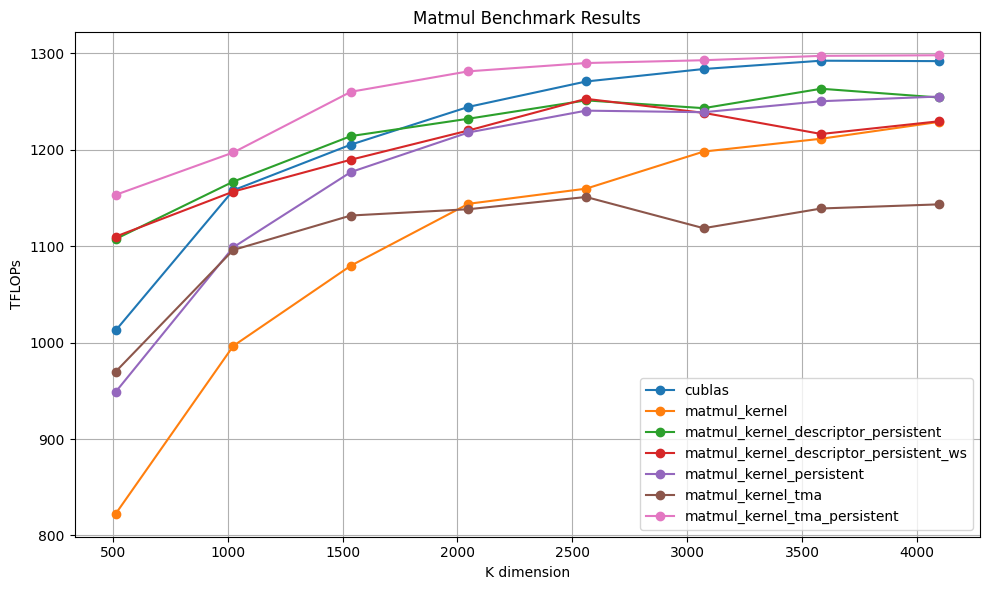

In [12]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict

log_file = "benchmark.log"  # 替换成你的日志文件

# 去掉 ANSI 颜色码的正则
ansi_escape = re.compile(r"\x1B\[[0-?]*[ -/]*[@-~]")

# 匹配 benchmark 行，例如：
# "1151.338 cublas [M=8192, N=8192, K=1024]"
pattern = re.compile(r"([\d\.]+) ([\d\.]+)\s+(\w+)\s+\[M=\d+, N=\d+, K=(\d+)\]")

data = defaultdict(dict)

with open(log_file, "r") as f:
    for raw_line in f:
        # 去掉颜色码
        line = ansi_escape.sub("", raw_line)
        match = pattern.search(line)
        if match:
            value = float(match.group(1))
            kernel = match.group(3)
            K = int(match.group(4))
            data[kernel][K] = value

# 画图
plt.figure(figsize=(10, 6))
for kernel, kv in data.items():
    Ks = sorted(kv.keys())
    vals = [kv[k] for k in Ks]
    plt.plot(Ks, vals, marker="o", label=kernel)

plt.xlabel("K dimension")
plt.ylabel("TFLOPs")
plt.title("Matmul Benchmark Results")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()